fitting a linear model to data with unknown gaussian errors
====

In [1]:
import numpy as np 
np.random.seed(42) # for repeatability 
theta_true = (25, 0.5, 10)
xdata = 100 * np.random.random(20)
xdata.sort()
ydata = theta_true[0] + theta_true[1] * xdata 
ydata = np.random.normal(ydata, theta_true[2]) # add error

plot fake data
---

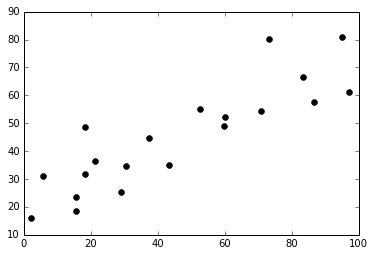

In [2]:
import matplotlib.pyplot as pl
%matplotlib inline

pl.plot(xdata, ydata, 'ko')

fit linear model with oridinary least squares (linear algebra)
---

In [3]:
X = np.vstack([np.ones_like(xdata), xdata]).T
theta_hat = np.linalg.solve(np.dot(X.T, X),
                            np.dot(X.T, ydata))
y_hat = np.dot(X, theta_hat)
sigma_hat = np.std(ydata - y_hat)
Sigma = sigma_hat ** 2 * np.linalg.inv(np.dot(X.T, X))
print "intercept: {}\nslope: {}\nsigma: {}".format(theta_hat[0], theta_hat[1], sigma_hat)

intercept: 20.7488267178
slope: 0.533275604154
sigma: 8.88508262065


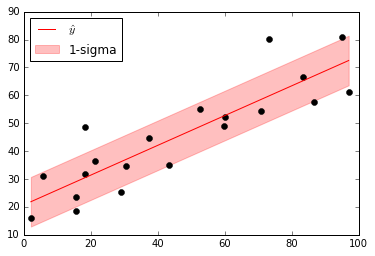

In [4]:
pl.plot(xdata, ydata, 'ko')
pl.plot(xdata, y_hat, 'r-', label='$\hat{y}$')
pl.fill_between(xdata, y_hat-sigma_hat, y_hat+sigma_hat, alpha=0.25, color='r', label='1-sigma')
pl.xlim(xdata.min(), xdata.max())
pl.legend(loc=2)

now with the statsmodels package
---

In [5]:
import statsmodels.api as sm # version 0.5
X = sm.add_constant(xdata)
result = sm.OLS(ydata, X).fit()
y_hat = result.fittedvalues
theta_hat = result.params
sigma_hat = np.std(ydata - y_hat)
Sigma = result.cov_params()
print "intercept: {}\nslope: {}\nsigma: {}".format(theta_hat[0], theta_hat[1], sigma_hat)
# print(result.summary2())

intercept: 20.7488267178
slope: 0.533275604154
sigma: 8.88508262065


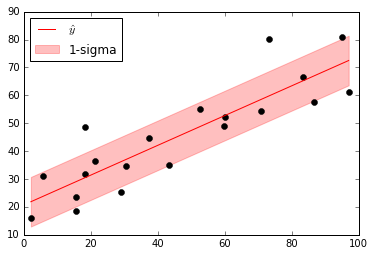

In [6]:
pl.plot(xdata, ydata, 'ko')
pl.plot(xdata, y_hat, 'r-', label='$\hat{y}$')
pl.fill_between(xdata, y_hat-sigma_hat, y_hat+sigma_hat, alpha=0.25, color='r', label='1-sigma')
pl.xlim(xdata.min(), xdata.max())
pl.legend(loc=2)

maximum likelihood estimation
---

In [7]:
from scipy import optimize as op

def log_like(theta, x, y): 
    alpha, beta, sigma = theta
    y_model = alpha + beta * x 
    return -0.5 * np.sum(np.log(2*np.pi*sigma**2) + (y-y_model)**2 / sigma**2)

x0 = (1,1,1)
args = (xdata, ydata)
nll = lambda *x: -log_like(*x)
nll(x0, xdata, ydata)
opt = op.minimize(nll, x0, args=args, method='nelder-mead')
print opt.message
theta_hat = opt.x
y_hat = np.dot(X, theta_hat[:2])
sigma_hat = theta_hat[2]
print "intercept: {}\nslope: {}\nsigma: {}".format(theta_hat[0], theta_hat[1], sigma_hat)

Optimization terminated successfully.
intercept: 20.7488187502
slope: 0.53327553286
sigma: 8.88508669936


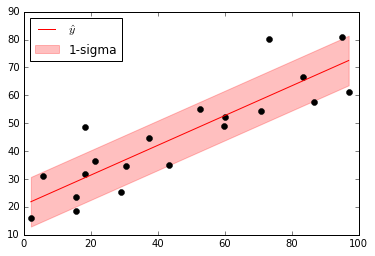

In [8]:
pl.plot(xdata, ydata, 'ko')
pl.plot(xdata, y_hat, 'r-', label='$\hat{y}$')
pl.fill_between(xdata, y_hat-sigma_hat, y_hat+sigma_hat, alpha=0.25, color='r', label='1-sigma')
pl.xlim(xdata.min(), xdata.max())
pl.legend(loc=2)

with emcee
---

In [9]:
import emcee # version 2.0
import multiprocessing

def log_prior(theta): 
    alpha, beta, sigma = theta
    if sigma < 0: 
        return -np.inf # log(0)
    else:
        return (-1.5 * np.log(1 + beta**2) - np.log(sigma))
    
def log_posterior(theta, x, y): 
    return log_prior(theta) + log_like(theta,x,y)

ncpu = multiprocessing.cpu_count()
ndim = 3 # number of parameters in the model 
nwalkers = 50 # number of MCMC walkers 
nburn = 1000 # "burn-in" to stabilize chains 
nsteps = 2000 # number of MCMC steps to take 
starting_guesses = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[xdata,ydata], threads=ncpu)
sampler.run_mcmc(starting_guesses, nsteps)

# chain is of shape (nwalkers, nsteps, ndim)
# discard burn-in points and reshape
trace = sampler.chain[:, nburn:, :] 
trace = trace.reshape(-1, ndim)

theta_hat = np.percentile(trace, 50, axis=0)
print "intercept: {}\nslope: {}\nsigma: {}".format(*theta_hat)

intercept: 20.9629739682
slope: 0.528270474326
sigma: 9.47575968579


walkers during burn-in
---

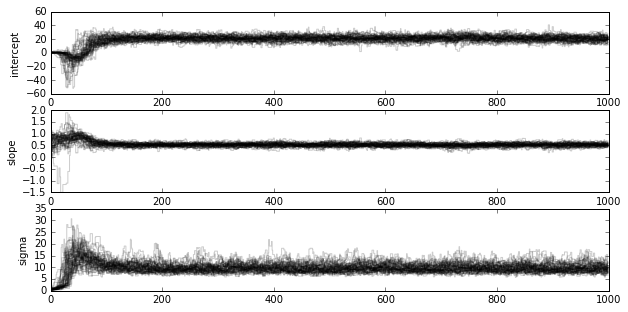

In [10]:
labels = ['intercept', 'slope', 'sigma']
fig = pl.figure(figsize=(10,5))
for i, chain in enumerate(sampler.chain[:, :nburn, :].T):
    pl.subplot(3, 1, i+1)
    pl.plot(chain, drawstyle='steps', color='k', alpha=0.2)
    pl.ylabel(labels[i])

walkers after burn-in
---

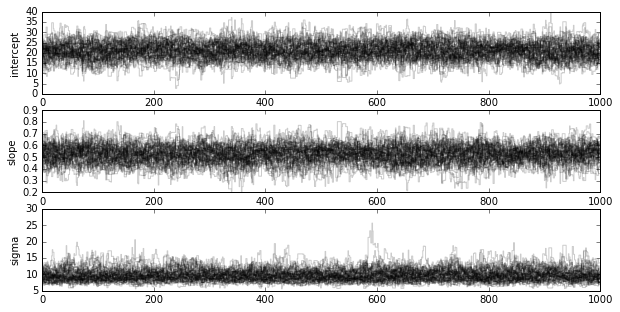

In [11]:
fig = pl.figure(figsize=(10,5))
for i, chain in enumerate(sampler.chain[:, nburn:, :].T):
    pl.subplot(3, 1, i+1)
    pl.plot(chain, drawstyle='steps', color='k', alpha=0.2)
    pl.ylabel(labels[i])

inspect posteriors
---

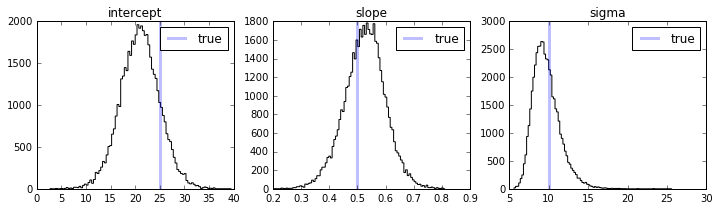

In [12]:
fig = pl.figure(figsize=(12,3))
for i in range(ndim):
    pl.subplot(1,3,i+1)
    pl.hist(trace[:,i], 100, color="k", histtype="step")
    yl = pl.ylim()
    pl.vlines(theta_true[i], yl[0], yl[1], color='blue', lw=3, alpha=0.25, label='true')
    pl.title("{}".format(labels[i]))
    pl.legend()

corner plot shows parameter covariance
---

/home/jhl/miniconda2/envs/pymc/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/home/jhl/miniconda2/envs/pymc/lib/python2.7/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


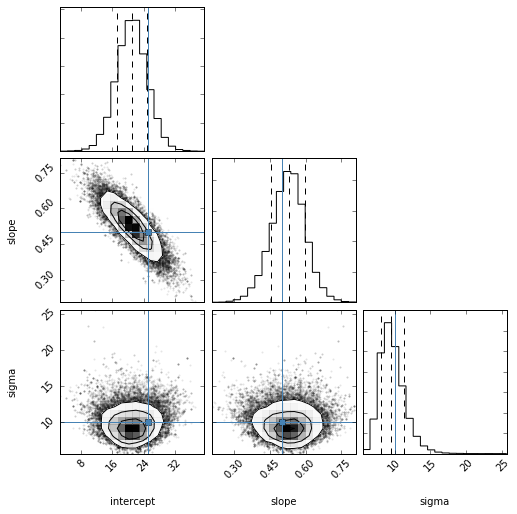

In [13]:
import corner
fig = corner.corner(trace, labels=labels, quantiles=[0.16, 0.5, 0.84], truths=theta_true)

plot projection of samples into space of observed data
---

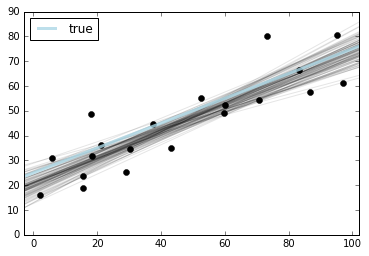

In [14]:
xmn, xmx = xdata.min(), xdata.max()
xl = np.array([xmn-10, xmx+10])
pl.plot(xdata, ydata, 'ko')
for b, m, s in trace[np.random.randint(len(trace), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
pl.plot(xl, theta_true[0] + xl * theta_true[1], color='lightblue', lw=3, alpha=0.8, label='true')
pl.xlim(xmn-5, xmx+5)
pl.legend(loc=2)

with PyMC
---

In [25]:
import pymc # version 2.3 

alpha = pymc.Uniform('alpha', -100, 100)

@pymc.stochastic(observed=False) 
def beta(value=0): 
    return -1.5 * np.log(1 + value**2)

@pymc.stochastic(observed=False) 
def sigma(value=1): 
    return -np.log(abs(value))

# Define the form of the model and likelihood 
@pymc.deterministic 
def y_model(x=xdata, alpha=alpha, beta=beta): 
    return alpha + beta * x

y = pymc.Normal('y', mu=y_model, tau=1./sigma**2, observed=True, value=ydata)
# package the full model in a dictionary 
model = dict(alpha=alpha, beta=beta, sigma=sigma, y_model=y_model, y=y)

S = pymc.MCMC(model) 
S.sample(iter=100000, burn=50000) 
trace = np.abs([S.trace('alpha')[:], S.trace('beta')[:], S.trace('sigma')[:]]).T
# np.abs: hack to get rid of negative sigma values
# --> need to learn how to impose priors in pymc

theta_hat = np.percentile(trace, 50, axis=0)
print "\nintercept: {}\nslope: {}\nsigma: {}".format(*theta_hat)

 [-----------------100%-----------------] 100000 of 100000 complete in 7.5 sec
intercept: 20.8984246321
slope: 0.528389386986
sigma: 9.57878150192


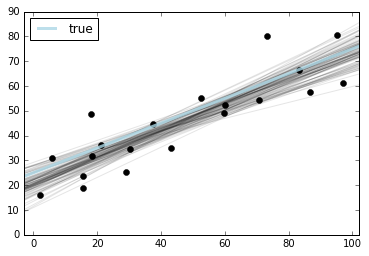

In [26]:
xmn, xmx = xdata.min(), xdata.max()
xl = np.array([xmn-10, xmx+10])
pl.plot(xdata, ydata, 'ko')
for b, m, s in trace[np.random.randint(len(trace), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
pl.plot(xl, theta_true[0] + xl * theta_true[1], color='lightblue', lw=3, alpha=0.8, label='true')
pl.xlim(xmn-5, xmx+5)
pl.legend(loc=2)

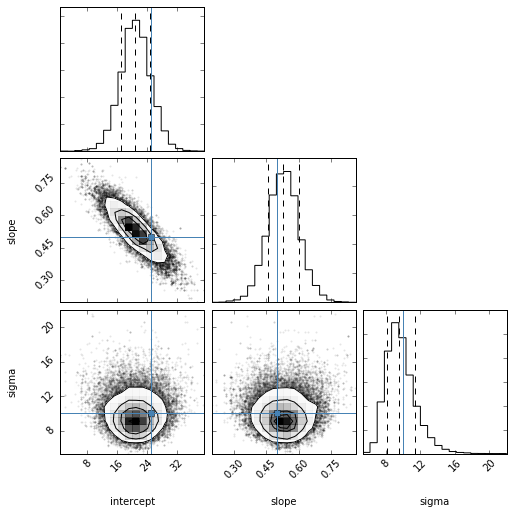

In [23]:
fig = corner.corner(trace, labels=labels, quantiles=[0.16, 0.5, 0.84], truths=theta_true)